# Create pose-balanced validation set

- use a version of the model reconstructions to create a pose-balanced validation set
- goal is to have same frequency of poses found across all ages

In [13]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from toolz import valmap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
path = Path('/home/wg41/groups/Dana/Ontogeny/raw_data/Ontogeny_males')
training_data_path = Path('/n/groups/datta/win/longtogeny/data/size_network/training_data')

In [3]:
# only keep files with the reconstruction key
def file_filter(path, key='win_size_norm_frames_v2'):
    with h5py.File(path, 'r') as f:
        return key in f.keys()

In [4]:
files = sorted(filter(file_filter, path.glob('**/results_00.h5')))

In [5]:
# open the files, get width/length/height of all sessions
morph_stats = []
for file in tqdm(files):
    with h5py.File(file, 'r') as h5f:
        a = h5f['scalars/area_mm']
        morph_stats.append(dict(
            file=str(file),
            age=Path(file).parents[2].name,
            mean_area=np.nanmean(a),
            median_area=np.nanmedian(a),
        ))
morph_stats = pd.DataFrame(morph_stats)

  0%|          | 0/216 [00:00<?, ?it/s]

In [6]:
avg_stat = morph_stats.groupby('age').median_area.mean().sort_values()
avg_stat / avg_stat['3months_19042021']

age
3wks_02112021        0.574222
5wks_02112021        0.784146
9wks_1811_2021       0.879794
7wks_18112021        0.902514
3months_19042021     1.000000
9months_060923       1.100214
6months_20042021     1.159622
22months_06052023    1.275754
12months_28042021    1.301784
18months_29042021    1.395657
Name: median_area, dtype: float32

In [7]:
# load in a subset of all frames, run PCA, load in more frames w/ PCA, apply kmeans clustering
n_frames = 1000

frames = []
for file in tqdm(files):
    with h5py.File(file, 'r') as h5f:
        frames.append(h5f['win_size_norm_frames_v2'][:n_frames].astype('uint8'))
frames = np.concatenate(frames)

  0%|          | 0/216 [00:00<?, ?it/s]

In [8]:
pca = PCA(n_components=15)
pca.fit(frames.reshape(len(frames), -1))

PCA(n_components=15)

In [9]:
pca.components_.shape

(15, 6400)

In [12]:
np.sum(pca.explained_variance_ratio_)

0.9558109844053696

In [10]:
components = pca.components_.reshape(-1, 80, 80)

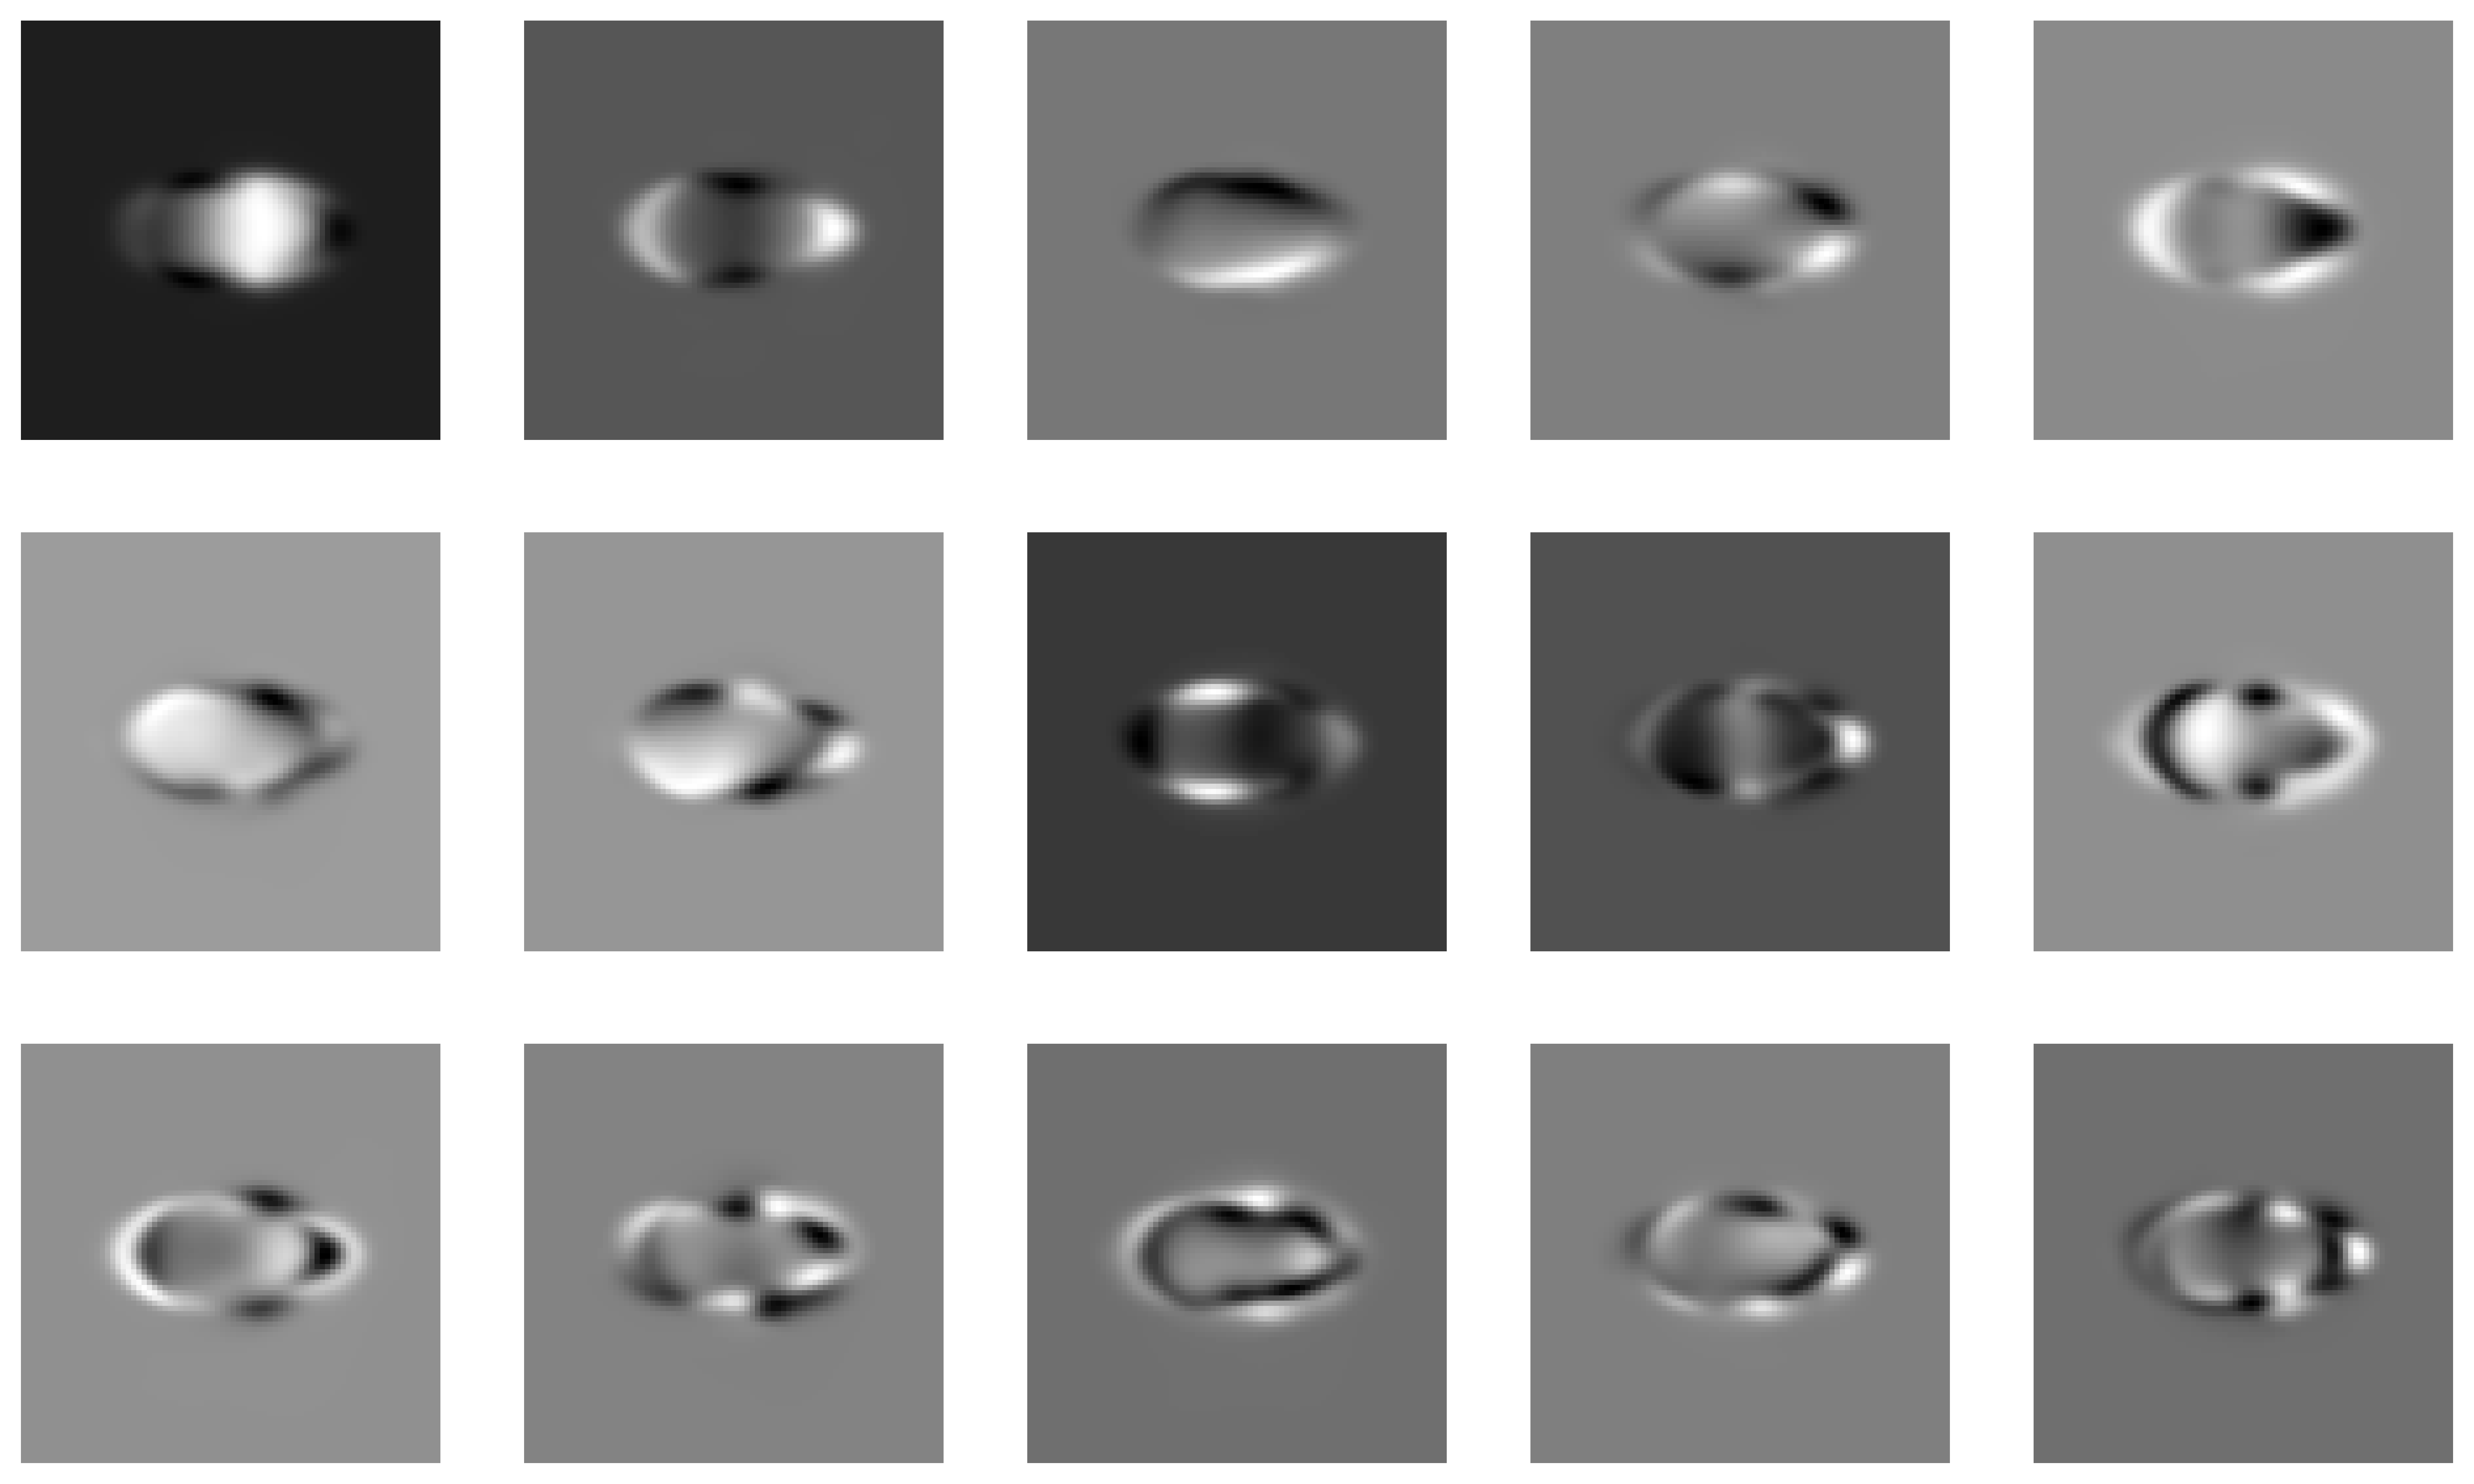

In [11]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9))
for i, a in enumerate(ax.ravel()):
    a.imshow(components[i], cmap='gray')
    # a.set_title(f'PCA component {i}')
    a.axis('off')

In [17]:
# load in more frames w/ PCA, apply kmeans clustering
n_frames = 4000

pcs = []
for file in tqdm(files):
    with h5py.File(file, 'r') as h5f:
        pcs.append(pca.transform(h5f['win_size_norm_frames_v2'][:n_frames].reshape(n_frames, -1)))
pcs = np.concatenate(pcs)

  0%|          | 0/216 [00:00<?, ?it/s]

In [18]:
km = KMeans(n_clusters=25)
km.fit(pcs)

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=25)

In [35]:
label_df = []
n_frames = 15_000

for file in tqdm(files):
    with h5py.File(file, "r") as h5f:
        _pcs = pca.transform(h5f["win_size_norm_frames_v2"][:n_frames].reshape(n_frames, -1))
        labels = km.predict(_pcs)
        label_df.append(
            pd.DataFrame(
                dict(
                    labels=labels,
                    file=str(file),
                    age=file.parents[2].name,
                    index=range(len(labels)),
                )
            ).astype(
                {"index": "int32", "file": pd.StringDtype(), "age": pd.StringDtype(), 'labels': 'uint8'}
            )
        )
label_df = pd.concat(label_df, ignore_index=True)

  0%|          | 0/216 [00:00<?, ?it/s]

In [36]:
label_df.groupby('age', sort=False)['labels'].apply(lambda s: s.value_counts().min())

age
12months_28042021    3375
18months_29042021    2752
22months_06052023    2677
3months_19042021     5322
3wks_02112021        1168
5wks_02112021        1591
6months_20042021     3668
7wks_18112021        2490
9months_060923       1559
9wks_1811_2021       2609
Name: labels, dtype: int64

In [43]:
sample = label_df.groupby(['age', 'labels']).sample(n=150, random_state=0)

In [46]:
sample = sample.sort_values(['file', 'index'])

In [44]:
sample.shape

(37500, 4)

In [47]:
sample.head()

,labels,file,age,index
38,24,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,38
86,4,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,86
530,6,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,530
696,3,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,696
1105,6,/home/wg41/groups/Dana/Ontogeny/raw_data/Ontog...,12months_28042021,1105


In [49]:
with h5py.File('/n/groups/datta/win/longtogeny/data/size_network/male_ontogeny_pose_balanced_validation.h5', 'w') as h5f:
    for age, df in tqdm(sample.groupby('age')):
        frames = []
        for file, df2 in df.groupby('file'):
            with h5py.File(file, 'r') as in_h5f:
                frames.append(in_h5f['frames'][df2['index'].to_numpy()])
        h5f.create_dataset(age.split('_')[0], data=np.concatenate(frames))

  0%|          | 0/10 [00:00<?, ?it/s]